In [1]:
import numpy as np
import networkx as nx
from dotmotif import Motif, GrandIsoExecutor
import matplotlib.pyplot as plt
from scipy.stats import ranksums
from lsmm_data import LSMMData
import json
from tqdm import tqdm
import scipy.stats as stats
import pandas as pd
# from collections import defaultdict
import pickle

with open('v1dd_wrangler_input_dict.json') as f:
    loaded_json = json.load(f)
my_data = LSMMData.LSMMData(loaded_json)
# with open('pyr_rect.data', 'wb') as f:
#     pickle.dump(my_data, f)

data_a = my_data.data
params_a = my_data.params
dirs_a = my_data.dirs
mappings_a = my_data.mappings

# Generate the chain results


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Generating Connectome...


100%|██████████| 137706/137706 [00:14<00:00, 9454.32it/s]


Generating Connectome...


100%|██████████| 137706/137706 [00:19<00:00, 7069.68it/s]


In [2]:
# Make a graph
cell_table = data_a['structural']['pre_cell'].copy()
cell_table['connectome_index'] = cell_table.index
post_cell_table = data_a['structural']['post_cell'].copy()
post_cell_table['connectome_index'] = post_cell_table.index

synapse_table = data_a['structural']['synapse']
# adjacency_matrix = data_a['structural']['binary_connectome']
binary_connectome = data_a['structural']['binary_connectome']
summed_size_connectome = data_a['structural']['summed_size_connectome']
pyr_graph = nx.from_numpy_array(binary_connectome, create_using=nx.DiGraph)


## Uncomment below to load existing chain motif analysis results
# two_chain_results_array = np.load('all_cell_two_chain_results_array.npy')
# three_chain_results_array = np.load('all_cell_three_chain_results_array.npy')
# four_chain_results_array = np.load('all_cell_four_chain_results_array.npy')

# Or uncomment below to generate new motif analysis results (Can take quite a while on larger graphs)
# Motif Analysis with DotMotif: 2 Chain, All Pyr
executor = GrandIsoExecutor(graph= pyr_graph)
chain_defs = Motif("""
                A -> B
                B -> C
              """)

chain_results = executor.find(chain_defs)



two_chain_results_array = np.array([list(c.values()) for c in tqdm(chain_results)])



chain_count_string_array = ['pyr_cell_2chain']
individual_assembly_indexes = [mappings_a['connectome_indexes_by_assembly'][f'A {i}'] for i in range(1,16)]
individual_post_assembly_indexes = [mappings_a['post_connectome_indexes_by_assembly'][f'A {i}'] for i in range(1,16)]

coregistered_post_cell_indexes = mappings_a['assemblies_by_post_connectome_index'].keys()
coregistered_cell_indexes = mappings_a['assemblies_by_connectome_index'].keys()
no_a_cell_indexes = mappings_a['connectome_indexes_by_assembly']['No A']
no_a_post_cell_indexes = mappings_a['post_connectome_indexes_by_assembly']['No A']
pooled_assembly_indexes = list(set(coregistered_cell_indexes) - set(no_a_cell_indexes))
pooled_assembly_post_indexes = list(set(coregistered_post_cell_indexes) - set(no_a_post_cell_indexes))

assembly_to_root_ids = mappings_a['pt_root_ids_by_assembly']
assembly_root_ids_set = set(mappings_a['assemblies_by_pt_root_id'].keys())

# Filter synapses_table to only synapses between two assembly cells (including No A)
synapses_df = synapse_table[synapse_table['pre_pt_root_id'].isin(assembly_root_ids_set)]
synapses_df = synapses_df[synapses_df['post_pt_root_id'].isin(assembly_root_ids_set)]

# Filter cell tables to only assembly cells (including 'No A')
assembly_cell_table = cell_table[cell_table['pt_root_id'].isin(assembly_root_ids_set)]
assembly_post_cell_table = post_cell_table[post_cell_table['pt_root_id'].isin(assembly_root_ids_set)]

assembly_pre_root_ids = set(assembly_cell_table['pt_root_id'].values)
assembly_post_root_ids = set(assembly_post_cell_table['pt_root_id'].values)
all_root_ids = assembly_pre_root_ids | assembly_post_root_ids


100%|██████████| 6052393/6052393 [00:05<00:00, 1138134.48it/s]


In [3]:
# Prep the sets

# Collect w and s
w = {}
s = {}
b = {}
for pre in assembly_pre_root_ids:
    for post in assembly_post_root_ids:
        w[(pre, post)] = 0
        s[(pre, post)] = 0
        b[(pre, post)] = 0

for i, row in synapses_df.iterrows():
    pre = row['pre_pt_root_id']
    post = row['post_pt_root_id']
    w[(pre, post)] += row['size']
    s[(pre, post)] += 1
    b[(pre, post)] = 1

# Split out assemblies and no_a
assembly_names = set(assembly_to_root_ids.keys()) - set(['No A'])
A_invert = {assembly: set(assembly_to_root_ids[assembly]) for assembly in assembly_names}
no_A = set(assembly_to_root_ids['No A'])
all_coregistered_root_ids = mappings_a['assemblies_by_pt_root_id'].keys()
assembly_root_ids_excluding_no_A = set(all_coregistered_root_ids) - no_A
A = {pt_root_id: set(mappings_a['assemblies_by_pt_root_id'][pt_root_id]) for pt_root_id in all_root_ids if 'No A' not in mappings_a['assemblies_by_pt_root_id'][pt_root_id]}

# C functions
def shared(pre, post, A):
    try:
        return not A[pre].isdisjoint(A[post])
    except KeyError:
        return False

def disjoint(pre, post, A):
    try:
        return A[pre].isdisjoint(A[post])
    except KeyError:
        return False

def shared_no_a(pre, post, A):
    return (pre in no_A) and (post in no_A)
    
def no_a_a(pre, post, A):
    return (pre in no_A) and (post not in no_A)

def a_no_a(pre, post, A):
    return (pre not in no_A) and (post in no_A)

C = [shared, disjoint, shared_no_a, no_a_a, a_no_a]


In [4]:
classification_map = cell_table.set_index('connectome_index')['classification_system'].to_dict()
backup_assembly_pre_root_ids = assembly_pre_root_ids
backup_assembly_post_root_ids = assembly_post_root_ids

# Initialize dictionaries for outbound weights
W_out_feed_forward_inhibition_chains = {c.__name__: {} for c in C}
W_out_excitatory_chains = {c.__name__: {} for c in C}

for c in C:
    for j in assembly_pre_root_ids:
        # Exclude the current pre-synaptic cell from the post-synaptic candidate set
        assembly_post_root_ids = backup_assembly_post_root_ids - set([j])

        # Calculate the normalizing factor as the number of post-synaptic cells matching the function 'c'
        normalizing_factor = len([i for i in assembly_post_root_ids if c(j, i, A)])

        # Skip if no valid post-synaptic connections
        if normalizing_factor > 0:
            for i in assembly_post_root_ids:
                # Check if pre-synaptic cell 'j' satisfies the condition with post-synaptic cell 'i'
                if c(j, i, A) and j != i:
                    pre_idx = mappings_a['pt_root_id_to_connectome_index'][j]
                    post_idx = mappings_a['pt_root_id_to_connectome_index'][i]

                    # Filter chains where cell A in chain matches pre_idx and cell C matches post_idx
                    temporary_chain_results = two_chain_results_array[(two_chain_results_array[:, 0] == pre_idx) & (two_chain_results_array[:, 2] == post_idx)]

                    # Continue if no matches are found
                    if len(temporary_chain_results) == 0:
                        continue

                    for chain in temporary_chain_results:  # Summing over possible intermediate nodes (k's)
                        cell_a, cell_b, cell_c = chain

                        # Calculate the chain weight using log-transformed values
                        weight_ik = np.log(summed_size_connectome[cell_a, cell_b]) # values shouldn't be zero
                        weight_kj = np.log(summed_size_connectome[cell_b, cell_c])
                        chain_weight = weight_ik + weight_kj  # Using addition since log(a * b) = log(a) + log(b)

                        # Classification of the intermediate node (cell B)
                        if classification_map[cell_b] == 'inhibitory':
                            W_out_feed_forward_inhibition_chains[c.__name__][j] = (
                                W_out_feed_forward_inhibition_chains[c.__name__].get(j, 0) +
                                chain_weight
                            )
                        elif classification_map[cell_b] == 'excitatory':
                            W_out_excitatory_chains[c.__name__][j] = (
                                W_out_excitatory_chains[c.__name__].get(j, 0) +
                                chain_weight
                            )

            # After accumulating the weights for all 'i' for this specific 'j', normalize them by # of 'i' that match the condition of c
            if j in W_out_feed_forward_inhibition_chains[c.__name__]:
                W_out_feed_forward_inhibition_chains[c.__name__][j] /= normalizing_factor

            if j in W_out_excitatory_chains[c.__name__]:
                W_out_excitatory_chains[c.__name__][j] /= normalizing_factor

# Initialize dictionaries for inbound weights
W_in_feed_forward_inhibition_chains = {c.__name__: {} for c in C}
W_in_excitatory_chains = {c.__name__: {} for c in C}

for c in C:
    for i in assembly_post_root_ids:
        # Exclude the current post-synaptic cell from the pre-synaptic candidate set
        assembly_pre_root_ids = backup_assembly_pre_root_ids - set([i])
        
        # Calculate the normalizing factor: count of pre-synaptic cells matching the condition 'c'
        normalizing_factor = len([j for j in assembly_pre_root_ids if c(j, i, A)])

        # Skip if there are no valid pre-synaptic connections
        if normalizing_factor > 0:
            for j in assembly_pre_root_ids:
                # Check if pre-synaptic cell 'j' satisfies the condition with post-synaptic cell 'i'
                if c(j, i, A) and j != i:
                    pre_idx = mappings_a['pt_root_id_to_connectome_index'][j]
                    post_idx = mappings_a['pt_root_id_to_connectome_index'][i]

                    # Filter chains where cell A in chain matches pre_idx and cell C matches post_idx
                    temporary_chain_results = two_chain_results_array[(two_chain_results_array[:, 0] == pre_idx) & (two_chain_results_array[:, 2] == post_idx)]

                    # Continue if no matches are found
                    if len(temporary_chain_results) == 0:
                        continue

                    for chain in temporary_chain_results:  # Summing over possible intermediate nodes (k's)
                        cell_a, cell_b, cell_c = chain

                        # Calculate the chain weight using log-transformed values
                        weight_ik = np.log(summed_size_connectome[cell_a, cell_b]) # values shouldn't be zero
                        weight_kj = np.log(summed_size_connectome[cell_b, cell_c])
                        chain_weight = weight_ik + weight_kj  # Using addition since log(a * b) = log(a) + log(b)

                        # Classification of the intermediate node (cell B)
                        if classification_map[cell_b] == 'inhibitory':
                            W_in_feed_forward_inhibition_chains[c.__name__][i] = (
                                W_in_feed_forward_inhibition_chains[c.__name__].get(i, 0) +
                                chain_weight
                            )
                        elif classification_map[cell_b] == 'excitatory':
                            W_in_excitatory_chains[c.__name__][i] = (
                                W_in_excitatory_chains[c.__name__].get(i, 0) +
                                chain_weight
                            )

            # After accumulating the weights for all 'j' for this specific 'i', normalize them by # of 'j' that match the condition of c
            if i in W_in_feed_forward_inhibition_chains[c.__name__]:
                W_in_feed_forward_inhibition_chains[c.__name__][i] /= normalizing_factor

            if i in W_in_excitatory_chains[c.__name__]:
                W_in_excitatory_chains[c.__name__][i] /= normalizing_factor



print(W_out_feed_forward_inhibition_chains)
print(W_out_excitatory_chains)


assembly_pre_root_ids = backup_assembly_pre_root_ids
assembly_post_root_ids = backup_assembly_post_root_ids

{'shared': {864691132807412738: 269.6392040527105, 864691132853487363: 245.52628954606033, 864691132834513288: 221.2124594610754, 864691132834925960: 244.99159427443442, 864691132636193294: 243.40933976490834, 864691132721900430: 168.02938981432322, 864691132771662867: 382.2754534137009, 864691132577861908: 193.66392997068922, 864691132734110231: 142.6080120151124, 864691132734110999: 228.13914666291524, 864691132738257819: 297.6907640257642, 864691132678493470: 313.93093652408777, 864691132770059681: 262.5867121161475, 864691132741590308: 346.4559650635919, 864691132635895079: 279.63937720008795, 864691132660826793: 235.4487209279986, 864691132720041642: 204.60499845259554, 864691132604748205: 484.4235030798421, 864691132731808307: 156.90646059866017, 864691132841658548: 222.7613961322871, 864691132595467831: 221.37586146231462, 864691132851739966: 172.75742295506913, 864691132598347327: 147.47178690904704, 864691132598451263: 302.7800846623386, 864691132712062021: 368.69747380617935,

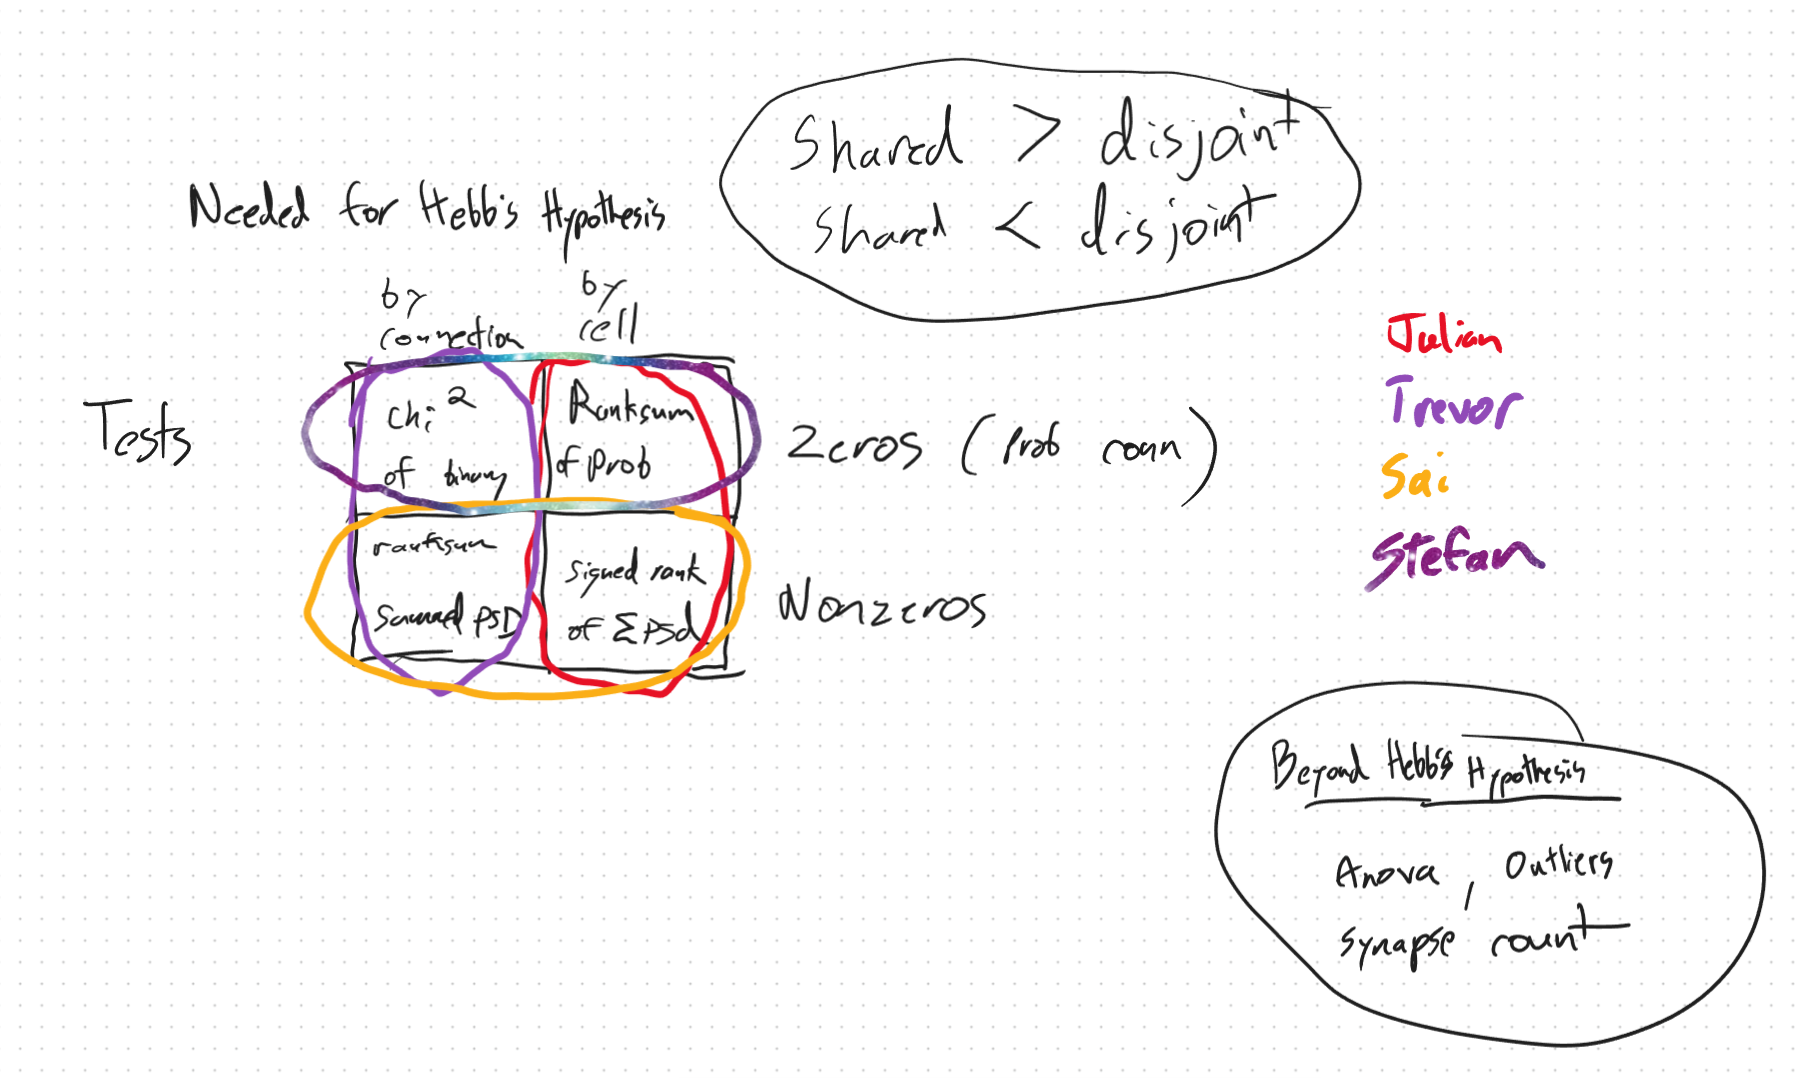

In [5]:
# Outbound Summed PSDs

print('\n\nSUMMED OUTBOUND PSDS for Feed-Forward Inhibitory CHAINS')
for c1 in C:
    for c2 in C:
        if c1.__name__ != c2.__name__:
            print(f'\n{c1.__name__} vs {c2.__name__}')
            result = stats.ranksums(list(W_out_feed_forward_inhibition_chains[c1.__name__].values()), list(W_out_feed_forward_inhibition_chains[c2.__name__].values()), alternative='greater')

            print('Greater:')
            print(result)
            if result.pvalue < 0.05:
                plt.figure()
                plt.boxplot([list(W_out_feed_forward_inhibition_chains[c1.__name__].values()), list(W_out_feed_forward_inhibition_chains[c2.__name__].values())])
                plt.title(f'OUTBOUND SUMMED PSDS: {c1.__name__} vs {c2.__name__}')




SUMMED OUTBOUND PSDS for Feed-Forward Inhibitory CHAINS

shared vs disjoint
Greater:
RanksumsResult(statistic=0.9082827083177103, pvalue=0.18186443796097057)

shared vs shared_no_a
Greater:
RanksumsResult(statistic=0.8713548411865623, pvalue=0.19178021750342533)

shared vs no_a_a
Greater:
RanksumsResult(statistic=0.8288497269823397, pvalue=0.20359472286767966)

shared vs a_no_a
Greater:
RanksumsResult(statistic=0.21029205562035655, pvalue=0.41671986768052094)

disjoint vs shared
Greater:
RanksumsResult(statistic=-0.9082827083177103, pvalue=0.8181355620390294)

disjoint vs shared_no_a
Greater:
RanksumsResult(statistic=0.4075695729696112, pvalue=0.34179485325516856)

disjoint vs no_a_a
Greater:
RanksumsResult(statistic=0.06113543594544168, pvalue=0.47562567405804207)

disjoint vs a_no_a
Greater:
RanksumsResult(statistic=-0.5484490220578043, pvalue=0.7083081881412521)

shared_no_a vs shared
Greater:
RanksumsResult(statistic=-0.8713548411865623, pvalue=0.8082197824965747)

shared_no_a vs



SUMMED OUTBOUND PSDS for Excitatory CHAINS

shared vs disjoint
Greater:
RanksumsResult(statistic=1.1527128561558289, pvalue=0.12451413141451417)

shared vs shared_no_a
Greater:
RanksumsResult(statistic=0.7237468644557459, pvalue=0.2346105780208697)

shared vs no_a_a
Greater:
RanksumsResult(statistic=1.924976258772545, pvalue=0.02711616422580734)

shared vs a_no_a
Greater:
RanksumsResult(statistic=-0.16030582178604505, pvalue=0.56367991346842)

disjoint vs shared
Greater:
RanksumsResult(statistic=-1.1527128561558289, pvalue=0.8754858685854858)

disjoint vs shared_no_a
Greater:
RanksumsResult(statistic=-0.16598500055174645, pvalue=0.5659156228734417)

disjoint vs no_a_a
Greater:
RanksumsResult(statistic=0.9339003219405991, pvalue=0.17517765638355848)

disjoint vs a_no_a
Greater:
RanksumsResult(statistic=-1.3522208504904916, pvalue=0.911847662243589)

shared_no_a vs shared
Greater:
RanksumsResult(statistic=-0.7237468644557459, pvalue=0.7653894219791303)

shared_no_a vs disjoint
Greater:

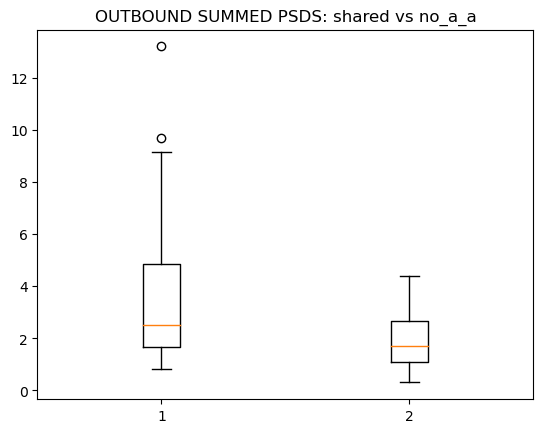

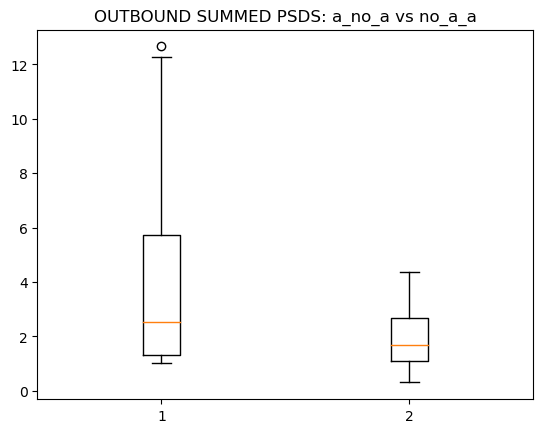

In [6]:
# Outbound Summed PSDs

print('\n\nSUMMED OUTBOUND PSDS for Excitatory CHAINS')
for c1 in C:
    for c2 in C:
        if c1.__name__ != c2.__name__:
            print(f'\n{c1.__name__} vs {c2.__name__}')
            result = stats.ranksums(list(W_out_excitatory_chains[c1.__name__].values()), list(W_out_excitatory_chains[c2.__name__].values()), alternative='greater')
            print('Greater:')
            print(result)
            if result.pvalue < 0.05:
                plt.figure()
                plt.boxplot([list(W_out_excitatory_chains[c1.__name__].values()), list(W_out_excitatory_chains[c2.__name__].values())])
                plt.title(f'OUTBOUND SUMMED PSDS: {c1.__name__} vs {c2.__name__}')



SUMMED INBOUND PSDS for Feed-Forward Inhibitory CHAINS

shared vs disjoint
Greater:
RanksumsResult(statistic=0.27830319404224163, pvalue=0.3903898122226318)

shared vs shared_no_a
Greater:
RanksumsResult(statistic=1.4768656253944359, pvalue=0.0698558304487479)

shared vs no_a_a
Greater:
RanksumsResult(statistic=1.771863668735605, pvalue=0.0382085952940825)

shared vs a_no_a
Greater:
RanksumsResult(statistic=0.32577918207230205, pvalue=0.3722957152586031)

disjoint vs shared
Greater:
RanksumsResult(statistic=-0.27830319404224163, pvalue=0.6096101877773682)

disjoint vs shared_no_a
Greater:
RanksumsResult(statistic=1.2275693084003065, pvalue=0.10980434454820603)

disjoint vs no_a_a
Greater:
RanksumsResult(statistic=1.4761001147007096, pvalue=0.06995850906169722)

disjoint vs a_no_a
Greater:
RanksumsResult(statistic=0.12483755678647185, pvalue=0.45032607696834187)

shared_no_a vs shared
Greater:
RanksumsResult(statistic=-1.4768656253944359, pvalue=0.9301441695512521)

shared_no_a vs dis

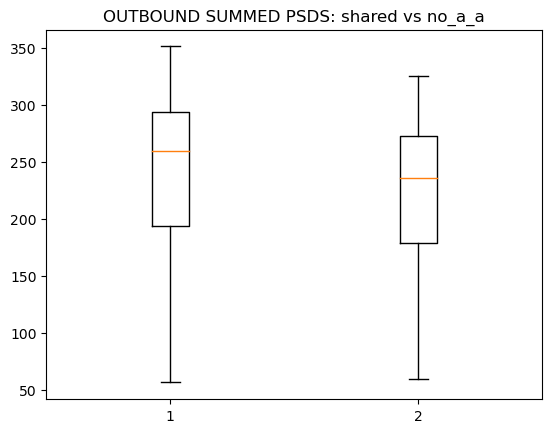

In [7]:
# Outbound Summed PSDs

print('\n\nSUMMED INBOUND PSDS for Feed-Forward Inhibitory CHAINS')
for c1 in C:
    for c2 in C:
        if c1.__name__ != c2.__name__:
            print(f'\n{c1.__name__} vs {c2.__name__}')
            result = stats.ranksums(list(W_in_feed_forward_inhibition_chains[c1.__name__].values()), list(W_in_feed_forward_inhibition_chains[c2.__name__].values()), alternative='greater')

            print('Greater:')
            print(result)
            if result.pvalue < 0.05:
                plt.figure()
                plt.boxplot([list(W_in_feed_forward_inhibition_chains[c1.__name__].values()), list(W_in_feed_forward_inhibition_chains[c2.__name__].values())])
                plt.title(f'OUTBOUND SUMMED PSDS: {c1.__name__} vs {c2.__name__}')

In [8]:
# Outbound Summed PSDs

print('\n\nSUMMED INBOUND PSDS for Excitatory CHAINS')
for c1 in C:
    for c2 in C:
        if c1.__name__ != c2.__name__:
            print(f'\n{c1.__name__} vs {c2.__name__}')
            result = stats.ranksums(list(W_in_excitatory_chains[c1.__name__].values()), list(W_in_excitatory_chains[c2.__name__].values()), alternative='greater')
            print('Greater:')
            print(result)
            if result.pvalue < 0.05:
                plt.figure()
                plt.boxplot([list(W_in_excitatory_chains[c1.__name__].values()), list(W_in_excitatory_chains[c2.__name__].values())])
                plt.title(f'OUTBOUND SUMMED PSDS: {c1.__name__} vs {c2.__name__}')



SUMMED INBOUND PSDS for Excitatory CHAINS

shared vs disjoint
Greater:
RanksumsResult(statistic=0.15453348185725116, pvalue=0.43859455678894066)

shared vs shared_no_a
Greater:
RanksumsResult(statistic=0.620453387463585, pvalue=0.2674796665679097)

shared vs no_a_a
Greater:
RanksumsResult(statistic=1.4004495992013235, pvalue=0.08068936306870589)

shared vs a_no_a
Greater:
RanksumsResult(statistic=0.41194292043554975, pvalue=0.3401906303963551)

disjoint vs shared
Greater:
RanksumsResult(statistic=-0.15453348185725116, pvalue=0.5614054432110593)

disjoint vs shared_no_a
Greater:
RanksumsResult(statistic=0.7237468644557459, pvalue=0.2346105780208697)

disjoint vs no_a_a
Greater:
RanksumsResult(statistic=1.123263821068591, pvalue=0.13066273220237684)

disjoint vs a_no_a
Greater:
RanksumsResult(statistic=0.22613350843332272, pvalue=0.41054879177597975)

shared_no_a vs shared
Greater:
RanksumsResult(statistic=-0.620453387463585, pvalue=0.7325203334320902)

shared_no_a vs disjoint
Greater: